# Recomendation systems:

# CF

In recommender systems, Collaborative Filtering (CF) is a canonical technique that predicts the interests of a user by aggregating information from similar users. ([Layer-refined Graph Convolutional Networks for Recommendation
](https://arxiv.org/abs/2207.11088))
Classic CF models first find the most similar users or items based on the historical interactions of a target user. They then recommend items that similar users have interacted with but not yet interacted by this user. ([Layer-refined Graph Convolutional Networks for Recommendation
](https://arxiv.org/abs/2207.11088))

# MF:
A more advanced method, Matrix Factorization (MF), decomposes the original sparse user-item interaction matrix into low-dimensional matrices with latent factors/features.
The ultimate objective of MF is to learn a set of informative user/item latent features to represent the preferences/attributes of users/items.



## GCN explanation:
### Ego Layer:
An ego layer refers to the initial layer of the network that represents the nodes and their immediate neighbors in the graph. This layer captures the local neighborhood information of each node in the graph. 


# Light GCN

Let's copy code for feature extraction from the notebook that we used on the lab. Downloaded from Moodle: <INSERT URL HERE>.


The authours of LightGCN have providethe following summary of their [work](https://paperswithcode.com/paper/lightgcn-simplifying-and-powering-graph/review/):
```
• We empirically show that two common designs in GCN, feature transformation and nonlinear activation, have no positive effect on the effectiveness of collaborative filtering.
• We propose LightGCN, which largely simplifies the model design by including only the most essential components in GCN for recommendation.
• We empirically compare LightGCN with NGCF by following the same setting and demonstrate substantial improvements. In-depth analyses are provided towards the rationality of LightGCN from both technical and empirical perspectives.
```
Although the over-simplified GCN, LightGCN, is efficient in computation, it is easily stuck into a sub-optimal space with shallow layers, due to the over-smoothing problem. 

## Difference between LightGCN and NGCF:
- LightGCN does not use feature transformation and non-linear activation
- NGCF uses weight matrices to transform the features of the nodes in each Layer, which are learned during training. LightGCN does not use these weights.
- NGCF uses a non-linear activation function (e.g. ReLU) after each layer. LightGCN does not use these activation functions.

In [1]:
# Standard library imports
import random

# Third-party imports
import matplotlib.pyplot as plt
# import networkx as nx
import numpy as np
import pandas as pd
# import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor

# from torch.utils.data import Dataset, DataLoader
import torch_geometric
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree
from tqdm.notebook import tqdm

pd.set_option("display.max_colwidth", None)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")
device

device(type='mps')

In [3]:
pd.read_csv("../data/raw/u.data",sep="\t")

,196,242,3,881250949
0,186,302,3,891717742
1,22,377,1,878887116
2,244,51,2,880606923
3,166,346,1,886397596
4,298,474,4,884182806
...,...,...,...,...
99994,880,476,3,880175444
99995,716,204,5,879795543
99996,276,1090,1,874795795
99997,13,225,2,882399156


In [4]:
from numpy import sort

n_users = 2593

columns_name=['user_id','item_id','rating','timestamp']
df = pd.read_csv("../data/raw/u.data",sep="\t", names=columns_name)

# for timestamp experiment
# df.sort_values(by=['timestamp', 'user_id'], inplace=True)

# For sorted timestamp experiment
train_df = df.iloc[:int(len(df)*0.8)]
test_df = df.iloc[int(len(df)*0.8):]
display(train_df.head(5))

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
# What's the distribution of highly rated movies?
print("Rating Distribution")
train_df.groupby(['rating'])['rating'].count()

Rating Distribution


rating
1     4952
2     8993
3    21668
4    27354
5    17033
Name: rating, dtype: int64

In [6]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()

train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['item_id'].values)

train_user_ids = train_df['user_id'].unique()
train_item_ids = train_df['item_id'].unique()

print(f"Number of unique users: {len(train_user_ids)}")
print(f"Number of unique movies: {len(train_item_ids)}")

test_df = test_df[
  (test_df['user_id'].isin(train_user_ids)) & \
  (test_df['item_id'].isin(train_item_ids))
]

print("Number of test entries after filtering out users/movies not in training set: ", len(test_df))

test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['item_id_idx'] = le_item.transform(test_df['item_id'].values)

print("Number of unique users in test set: ", len(test_df['user_id'].unique()))
print("Number of unique movies in test set: ", len(test_df['item_id'].unique()))

Number of unique users: 943
Number of unique movies: 1650
Number of test entries after filtering out users/movies not in training set:  19964
Number of unique users in test set:  927
Number of unique movies in test set:  1375


/var/folders/q0/vpk5v54j4qdd98h1jzgt1ftr0000gn/T/ipykernel_45590/195348969.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
/var/folders/q0/vpk5v54j4qdd98h1jzgt1ftr0000gn/T/ipykernel_45590/195348969.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['item_id_idx'] = le_item.fit_transform(train_df['item_id'].values)


In [7]:
n_users = train_df['user_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()
n_users, n_items


(943, 1650)

# Batch (minibatch) sampling

<!-- TODO: Try to explain -->
We will use it later to sample minibatch dataframe up to ```n_usr```. So, the batch will be created randomly and will have the same size

In [8]:
def data_loader(data, batch_size, n_usr, n_itm):
    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = (
        data.groupby("user_id_idx")["item_id_idx"].apply(list).reset_index()
    )
    indices = [x for x in range(n_usr)]
    # sample users to fit in batch size
    # if number of users is less than batch size, then sample with replacement
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users, columns=["users"])

    # Merge the two dataframes based on user_id_idx
    interected_items_df = pd.merge(
        interected_items_df,
        users_df,
        how="right",
        left_on="user_id_idx",
        right_on="users",
    )
    pos_items = (
        interected_items_df["item_id_idx"].apply(lambda x: random.choice(x)).values
    )
    neg_items = interected_items_df["item_id_idx"].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device),
        torch.LongTensor(list(pos_items)).to(device) + n_usr,
        torch.LongTensor(list(neg_items)).to(device) + n_usr,
    )


data_loader(train_df, 16, n_users, n_items)

(tensor([ 59,  78, 173, 226, 230, 262, 265, 405, 434, 437, 515, 526, 531, 604,
         737, 759], device='mps:0'),
 tensor([1450, 1275, 1681, 1952, 1194, 1028, 1225,  995, 1871, 1197, 1123, 1077,
          949, 1069, 1322, 1307], device='mps:0'),
 tensor([1368, 2174, 1259, 2028, 2129, 1886, 1350, 2287, 2311, 1677, 2288, 1861,
         2272, 1065, 1810, 1024], device='mps:0'))

# Edge index
Create edge indexes for training to embedding edges with LightGCN

In [9]:
u_t = torch.LongTensor(train_df.user_id_idx)
i_t = torch.LongTensor(train_df.item_id_idx) + n_users

train_edge_index = torch.stack((
  torch.cat([u_t, i_t]),
  torch.cat([i_t, u_t])
)).to(device)
train_edge_index

tensor([[ 195,  185,   21,  ..., 1300, 1690, 1950],
        [1184, 1244, 1319,  ...,  830,  460,  276]], device='mps:0')

In [10]:
train_edge_index[:,-1], train_edge_index[:, 0]

(tensor([1950,  276], device='mps:0'), tensor([ 195, 1184], device='mps:0'))

In [11]:
train_edge_index[:, len(train_df)-1], train_edge_index[:, len(train_df)]

(tensor([ 276, 1950], device='mps:0'), tensor([1184,  195], device='mps:0'))

# LightGCNConv Layer
The LightGCN architecture is governed by the following rules:

$$e_{u}^{(k+1)} = \sum\limits_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}}e^{(k)}_i$$

$$e_{i}^{(k+1)} = \sum\limits_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}}e^{(k)}_u$$
In essence, the embedding for each node after a single LightGCN layer is the sum of the synthetic normalized embeddings of it's neighbors before the layer.

In [12]:
class LightGCNConv(MessagePassing):
  def __init__(self, **kwargs):
    super().__init__(aggr='add')

  def forward(self, x, edge_index):
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages (no update after aggregation)
    return self.propagate(edge_index, x=x, norm=norm)

  def message(self, x_j, norm):
    return norm.view(-1, 1) * x_j

In [13]:
test_x = torch.Tensor(np.eye(5))
test_edge_index = torch.LongTensor(np.array([
  [0, 0, 1, 1, 2, 3, 3, 4],
  [2, 3, 3, 4, 0, 0, 1, 1]
]))

LightGCNConv()(test_x, test_edge_index)

tensor([[0.0000, 0.0000, 0.7071, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.7071],
        [0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7071, 0.0000, 0.0000, 0.0000]])

In [14]:
class RecSysGNN(nn.Module):
  def __init__(
      self,
      latent_dim,
      num_layers,
      num_users,
      num_items,
      model, # 'LightGCN'
  ):
    super(RecSysGNN, self).__init__()

    assert (model == 'LightGCN'), \
        'Model must be LightGCN'
    self.model = model
    self.embedding = nn.Embedding(num_users + num_items, latent_dim)

    self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

    self.init_parameters()


  def init_parameters(self):
      # Authors of LightGCN report higher results with normal initialization
      nn.init.normal_(self.embedding.weight, std=0.1)


  def forward(self, edge_index):
    emb0 = self.embedding.weight
    embs = [emb0]

    emb = emb0
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)
      embs.append(emb)

    out = torch.mean(torch.stack(embs, dim=0), dim=0)
    
    return emb0, out


  def encode_minibatch(self, users, pos_items, neg_items, edge_index):
    emb0, out = self(edge_index)
    return (
        out[users],
        out[pos_items],
        out[neg_items],
        emb0[users],
        emb0[pos_items],
        emb0[neg_items]
    )

## Loss function and metrics

We implement both the Bayesian Personalized Ranking loss function for a single minibatch of users, positive items, and negative items, as well as the precision@K and recall@K metrics.

In [15]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0, pos_emb0, neg_emb0):
    # compute loss from initial embeddings, used for regulization
    reg_loss = (
        (1 / 2)
        * (user_emb0.norm().pow(2) + pos_emb0.norm().pow(2) + neg_emb0.norm().pow(2))
        / float(len(users))
    )

    # compute BPR loss from user, positive item, and negative item embeddings
    pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
    neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

    bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

    return bpr_loss, reg_loss

In [16]:
def get_metrics(
    user_Embed_wts: Tensor,
    item_Embed_wts: Tensor,
    n_users: int,
    n_items: int,
    train_data: pd.DataFrame,
    test_data: pd.DataFrame,
    K: int,
    metric: list[str] = ["recall"],
):
    all_metrix = ['recall', 'precision', 'ndcg', 'hit_ratio']

    # test_user_ids = torch.LongTensor(test_data["user_id_idx"].unique())
    # compute the score of all user-item pairs
    relevance_score = torch.matmul(
        user_Embed_wts, torch.transpose(item_Embed_wts, 0, 1)
    )

    # create dense tensor of all user-item interactions
    # create tensor with all users and items entities
    i = torch.stack(
        (
            torch.LongTensor(train_data["user_id_idx"].values),
            torch.LongTensor(train_data["item_id_idx"].values),
        )
    )
    # create matrix to store prediction results for each user
    v = torch.ones((len(train_data)), dtype=torch.float32)

    # Store the user-item interactions in a dense tensor format.
    interactions_t = (
        torch.sparse.FloatTensor(i, v, (n_users, n_items)).to_dense().to(device)
    )

    # mask out training user-item interactions from metric computation
    relevance_score = torch.mul(relevance_score, (1 - interactions_t))

    # compute top scoring items for each user
    # get top K - relevance entries
    topk_relevance_indices = torch.topk(relevance_score, K).indices
    topk_relevance_indices_df = pd.DataFrame(
        topk_relevance_indices.cpu().numpy(),
        columns=["top_indx_" + str(x + 1) for x in range(K)],
    )
    topk_relevance_indices_df["user_ID"] = topk_relevance_indices_df.index

    # create a new column with most relevant items for each user
    topk_relevance_indices_df["top_rlvnt_itm"] = topk_relevance_indices_df[
        ["top_indx_" + str(x + 1) for x in range(K)]
    ].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[["user_ID", "top_rlvnt_itm"]]

    # measure overlap between recommended (top-scoring) and held-out user-item
    # interactions
    test_interacted_items = (
        test_data.groupby("user_id_idx")["item_id_idx"].apply(list).reset_index()
    )
    metrics_df = pd.merge(
        test_interacted_items,
        topk_relevance_indices_df,
        how="left",
        left_on="user_id_idx",
        right_on=["user_ID"],
    )
    metrics_df["intrsctn_itm"] = [
        list(set(a).intersection(b))
        for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)
    ]

    metrics_df["recall"] = metrics_df.apply(
        lambda x: len(x["intrsctn_itm"]) / len(x["item_id_idx"]), axis=1
    )
    metrics_df["precision"] = metrics_df.apply(
        lambda x: len(x["intrsctn_itm"]) / K, axis=1
    )

    return metrics_df["recall"].mean(), metrics_df["precision"].mean()

## Train and evaluate models

Now that we've implemented both LightGCN and NGCF in PyG, we can train and evaluate their performance!

In [17]:
latent_dim = 64
n_layers = 3

EPOCHS = 20
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 20

In [18]:
def train_and_eval(model: RecSysGNN, optimizer: torch.optim.Optimizer, train_df, check_smoothing=False):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []
  conv_weights_list_epoch = []
  recall_list = []
  precision_list = []

  for epoch in tqdm(range(EPOCHS)):
      n_batch = int(len(train_df)/BATCH_SIZE)

      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []

      model.train()
      for batch_idx in range(n_batch):

          optimizer.zero_grad()

          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss

          final_loss.backward()
          optimizer.step()

          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      model.eval()
      with torch.no_grad():
          _, out = model(test_edge_index)
          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
          test_topK_recall,  test_topK_precision = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K, test_data=True
          )

      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))
      if check_smoothing:
        conv_weights_list_epoch.append([conv.state_dict() for conv in model.convs])

  return (
    loss_list_epoch,
    bpr_loss_list_epoch,
    reg_loss_list_epoch,
    recall_list,
    precision_list,
    conv_weights_list_epoch
  )

### Train and eval LightGCN

In [19]:
lightgcn = RecSysGNN(
  latent_dim=latent_dim,
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
  model='LightGCN'
)
lightgcn.to(device)
lightgcn.load_state_dict(torch.load("../models/lightgcn.pt"))
optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([2593, 64])]


In [20]:
def train_and_eval(model: RecSysGNN, optimizer: torch.optim.Optimizer, train_df, check_smoothing=False):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []
  conv_weights_list_epoch = []
  recall_list = []
  precision_list = []

  # Store just the first layer
  weights = {k: v.clone() for k, v in model.convs[0].named_parameters()}
  updates = {k: v.clone() for k, v in model.convs[0].named_parameters()}
  conv_weights_list_epoch.append(weights)
  for epoch in tqdm(range(EPOCHS)):
      n_batch = int(len(train_df)/BATCH_SIZE)

      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []

      model.train()
      for batch_idx in range(n_batch):

          optimizer.zero_grad()

          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss

          final_loss.backward()
          optimizer.step()

          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      model.eval()
      with torch.no_grad():
          _, out = model(train_edge_index)
          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
          test_topK_recall,  test_topK_precision = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K
          )

      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))
      if check_smoothing:
        new_weights = {k: v.clone() for k, v in model.convs[0].named_parameters()}

        conv_weights_list_epoch.append(new_weights)

  return (
    loss_list_epoch,
    bpr_loss_list_epoch,
    reg_loss_list_epoch,
    recall_list,
    precision_list,
    conv_weights_list_epoch
  )

In [21]:
light_loss, light_bpr, light_reg, light_recall, light_precision, conv_weights = train_and_eval(lightgcn, optimizer, train_df, check_smoothing=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [22]:
epoch_list = [(i+1) for i in range(EPOCHS)]

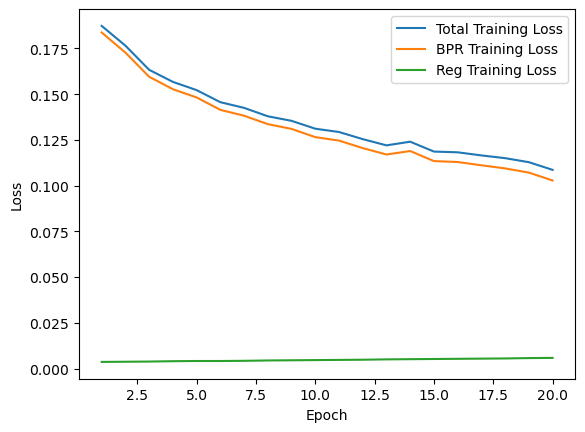

In [23]:
plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [24]:
light_precision_np = np.array(light_precision)
light_recall_np = np.array(light_recall)

In [25]:
f1_score = 2*(light_precision_np * light_recall_np)/(light_precision_np+light_recall_np)

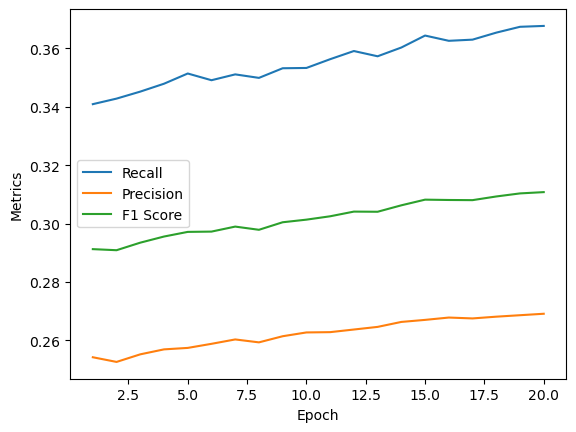

In [26]:
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.plot(epoch_list, f1_score, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

In [27]:
torch.save(lightgcn.state_dict(), "../models/lightgcn.pt")
